# Train Accidents in India

## Table of Contents
1. [Abstract](#abs)
2. [Introduction](#intro)
3. [Collecting data](#cdata)
4. [Data Pre-Processing](#dprep)
5. [Feature Engineering](#feng)
6. [Feature Selection](#fsel)
7. [Exploratory Data Analysis](#eda)
8. [Answers](#ans)
9. [Conclusion](#conc)
10. [Abbreviations used](#abb)
11. [References](#refs)

<a id='abs'></a>
## 1. Abstract

Train is the most common mode of travel for long distance journey in India. This year India has seen major accidents in railways due to several factors including natural causes and human error. We have tried to study the causes of train accidents for year 2002-2017, and other factors which trigger train accidents in different parts of the country. This report includes major accidents till 2017 which impacted the customer experience or say made it unsafe to travel in train.

*Keywords:* Train accidents; inferential statistics; data visualisation; ggplot2

<a id='intro'></a>
# 2. Introduction

Data was collected from various news websites, online news archives, Wikipedia articles[1], etc. Data was available on the internet from year 1890-2017 but analysis is carried out for 2002- 2017 because news reports on many old incidents needed citations and some of them were reported in less detail on news websites. To cover major features affecting the accident rate in India and to closely compare them, 2002-2017 year range provided enough observations (114) to make some statistical conclusion. First, let's perform some preliminary steps of data wrangling to convert our data to tidy form.

<a id='cdata'></a>
# 3. Collecting data

Data was collected from online news archives[2] and converted to tidy form. Here is a preview of top few rows of data set:

In [2]:
# import packages
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import seaborn as sns

# hide warnings
import warnings
warnings.filterwarnings('ignore')


df = pd.read_csv("DoMS_2.5.2.csv")
df.head()

,X,environment,train_name,injured,killed,triggering_factor,time,railway_division,cause,env
0,1,open rail track|over 2000 attackers,Sabarmati Express,43.0,58.0,attack by a mob at Godhra station in Gujarat a...,27-02-2002 08:30,w,attack,open
1,2,open rail track,Shramjeevi Express,80.0,12.0,crash occurred when sabotage derailed the Shr...,13-05-2002 03:00,n,attack,open
2,3,collision on a manned level crossing,Kanpur Kasganj Express,29.0,49.0,Express collided with a passenger bus near the...,04-06-2002 13:00,ne,unclear track,busy
3,4,natural on a bridge over Dhave river,Howrah-Rajdhani Express,150.0,140.0,derailed on a bridge between Gaya and Dehri-on...,09-09-2002 22:40,ec,attack,water
4,5,open rail track,Golden Temple Mail,15.0,36.0,three coaches caught fire,15-05-2003 03:15,n,fire,open


In order to generate useful results this dataset needs to be in structured format. `Environment` column contains entries which are in sentence form. First we will check for data types and then use some of the descriptive columns to create factor variables.

<a id='dprep'></a>
## 4. Data pre-processing

Checking for data types:

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 10 columns):
X                    114 non-null int64
environment          106 non-null object
train_name           114 non-null object
injured              110 non-null float64
killed               111 non-null float64
triggering_factor    89 non-null object
time                 114 non-null object
railway_division     114 non-null object
cause                114 non-null object
env                  114 non-null object
dtypes: float64(2), int64(1), object(7)
memory usage: 9.0+ KB


Data types for all variables are correct except `time` column. `Time` column needs to be a datetime object. Converting time column to datetime object:

In [4]:
df['time'] = pd.to_datetime(df['time'])

Verifying:

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 10 columns):
X                    114 non-null int64
environment          106 non-null object
train_name           114 non-null object
injured              110 non-null float64
killed               111 non-null float64
triggering_factor    89 non-null object
time                 114 non-null datetime64[ns]
railway_division     114 non-null object
cause                114 non-null object
env                  114 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(6)
memory usage: 9.0+ KB


<a id='feng'></a>
## 5. Feature engineering

Data type correction being done, next we will create some new columns from the existing ones to create meaningful visualisations.

### **5.1.** Hour, daytime and season

`Time` column will be helpful in creating these columns:

#### 5.1.1. Hour

Creating hour column:

In [6]:
df['hour'] = df['time'].dt.hour

In [7]:
df.hour.unique()

array([ 8,  3, 13, 22,  5, 11, 17, 21,  4, 18, 23,  2, 19,  1,  9,  6, 16,
       12, 20,  7, 14,  0])

For comparing accident trends over a single day, only the hour column is not sufficient. It will produce numerical values with 24 levels to consider for each day.

It is better to divide each day in interval of 6 hours to better compare accidents over a single day. These time intervals are chosen to see the effect of visibility on accident.

#### 5.1.2. Daytime

Creating daytime column:

In [8]:
df['daytime'] = pd.cut(df['hour'], [0,6,12,18,24])

In [9]:
df['daytime'] = df['daytime'].astype(str)

In [10]:
df.daytime.value_counts()

(0, 6]      47
(6, 12]     26
(18, 24]    25
(12, 18]    14
nan          2
Name: daytime, dtype: int64

This feature will be helpful in studying the daily trends in accident.

#### 5.1.3. Season

Creating season column:

In [11]:
seasons = []

for i in df["time"]:
    if i.month in range(4,7):
        seasons.append("summer")
    elif i.month in range(7,10):
        seasons.append("monsoon")
    elif i.month in range(10,12):
        seasons.append("autumn")
    else:
        seasons.append("winter")

df["season"] = seasons
df["season"].value_counts()

winter     39
summer     29
monsoon    27
autumn     19
Name: season, dtype: int64

The month value used as boundary condition for any two consecutive season is just for convenience to create `season` column effectively with code. These intervals are taken from Wikipedia article on **Climate of India**[3].


### 5.2.  Type of train

`train_name` column is just a label and will not help in studying accidents. It will be difficult to study number of accidents for each and every train. Instead, we will create a new column which will show type of train involved in accident, like express, passenger, freight, etc.

Creating `train_type` column:

In [12]:
train_types = ["Express", "Passenger", "Freight", "Mail", "others"]
train_type = []

for i in df['train_name']: 
    for t_type in train_types: 
        if t_type in i: # check the train type
            train_type.append(t_type)

df['train_type'] = train_type

In [13]:
df['train_type'].value_counts()

Express      76
Passenger    12
others       12
Freight      10
Mail          4
Name: train_type, dtype: int64

### 5.3. Country region

Now we have `railway_division` column. 17 values for railway division column are too much and will make our graph look messy. Categorising them into North, South, East, West and Central will make our study simple. For example, n, nc, ne, nef, nw (abbreviations are provided at the end of report) will go in North area, and similarly for other regions.

Creating **region** column:

In [14]:
reg = []

for div in df['railway_division']:
    if div in ['n', 'nc', 'ne', 'nef', 'nw']: # North divison
        reg.append('North')
    elif div in ['s', 'sc', 'se', 'sw']: # South
        reg.append('South')
    elif div in ['e', 'ec', 'eco']: # East
        reg.append('East')
    elif div in ['c']: # Central
        reg.append("Central")
    else: # West
        reg.append("West")
        
df['region'] = reg
df['region'].value_counts()

North      52
South      28
East       15
Central    10
West        9
Name: region, dtype: int64

<a id='fsel'></a>
## 6. Feature selection

Next part is including relevant features for visualisation purpose.
We have 15 variables in our data.

In [15]:
df.shape[1]

15

In [16]:
df.columns

Index(['X', 'environment', 'train_name', 'injured', 'killed',
       'triggering_factor', 'time', 'railway_division', 'cause', 'env', 'hour',
       'daytime', 'season', 'train_type', 'region'],
      dtype='object')

We are removing columns which are not important for analysis. We are removing these columns due to the following reasons:

* they are not in a structured format.

* some of them were in complex form and new derived columns are used instead.

The columns which are to be removed are:

### 6.1. Environment

`Environment` column is descriptive in nature, `env` column is more specific in describing the environment of accident spot, like open area, level-crossing, etc.

### 6.2. Train_name

Too many distinct values are there for this variable. This was used to create `train_type` column previously.
 
### 6.3. Triggering_factor

This one is also descriptive in nature and `cause` column shows the specific cause, like human error, technical fault, etc.

Removing the above mentioned columns:

In [17]:
df.drop(['environment', 'triggering_factor', 'train_name', 'X'], axis = 1, inplace = True)

In [18]:
df.head()

,injured,killed,time,railway_division,cause,env,hour,daytime,season,train_type,region
0,43.0,58.0,2002-02-27 08:30:00,w,attack,open,8,"(6, 12]",winter,Express,West
1,80.0,12.0,2002-05-13 03:00:00,n,attack,open,3,"(0, 6]",summer,Express,North
2,29.0,49.0,2002-04-06 13:00:00,ne,unclear track,busy,13,"(12, 18]",summer,Express,North
3,150.0,140.0,2002-09-09 22:40:00,ec,attack,water,22,"(18, 24]",monsoon,Express,East
4,15.0,36.0,2003-05-15 03:15:00,n,fire,open,3,"(0, 6]",summer,Mail,North


We have done these tasks till now :

* Correcting data types

* Creating useful columns from the given ones

* Removing columns that are not important for analysis

Next part is generating bivariate and multivariate plots to derive a conclusion about year by year trends.

<a id='eda'></a>
## 7. Exploratory data analysis

After correcting data types and performing feature extraction on the data set, next part is creating visualisations to get insights about what are the major causes of accidents, where they are more frequent and many more features which show different frequency of accidents.

We will use this data to answer the following questions:

**Q1.** On which time of day more accidents are happening? Does visibility play a major role in accidents?

**Q2.** In which season accidents are more frequent?

**Q3.** Which region of the country has experienced more accidents?

**Q4.** What is the environment of accident spot (like open area, flood affected area or bad track?

**Q5.** Which type of trains suffer more accidents(express, passenger, freight, etc.)?

**Q6.** What are the major causes for accidents? Is there any significant difference across different causes? Most of the factors result in derailment of train as we see in news reports, but here we will try to investigate the cause for these derailments. Whether it is human error, natural cause or technical glitch.



We have 6 features in our data which will help in answering these questions. First we will see the distribution of accident count based on each feature and then will include more features to better understand the trends.

We have 6 features on which we can categorise our analysis:

* [Region](#reg)
* [Daytime](#dayt)
* [Cause](#cz)
* [Environment](#env)
* [Season](#season)
* [Train type](#t_type)

<a id='reg'></a>
### 7.1. Region

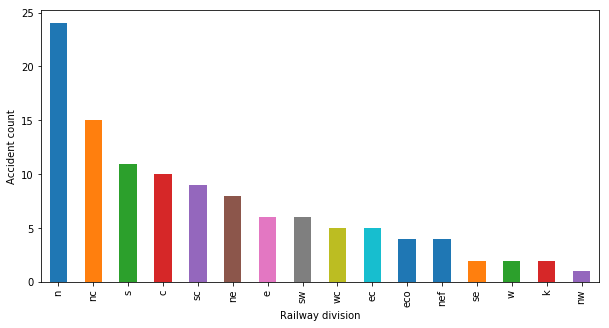

In [19]:
plt.figure(figsize=(10,5))
plt.xlabel("Railway division")
plt.ylabel("Accident count")
df['railway_division'].value_counts().plot(kind='bar');

The distribution based on railway division shows peaks at regions which are more general (say larger in area), like if we consider **n, nc, ne, nef** and **nw** then they collectively represent accidents that occur in North India. Some of the accidents are hard to categorize based on such granular distinction.

To tackle this problem, we will see accidents in different parts of India, i.e., North, East, West, South and Central to classify them more clearly with less overlapping regions.

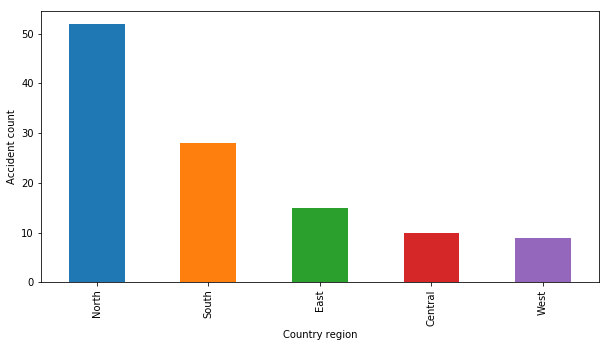

In [20]:
plt.figure(figsize=(10,5))
plt.xlabel("Country region")
plt.ylabel("Accident count")
df['region'].value_counts().plot(kind='bar');

Accident count in South is almost half of that in North region. In North region, the state which contributed largest to the accident count is U.P.. Accidents in U.P. are so frequent that there is an entire Wikipedia article on it[4].

<a id='dayt'></a>
### 7.2. Daytime

Another column which has many levels is **hour** column.

Let us see the trends based on hour and then we will use **daytime** column for considering visibility effect on accidents.

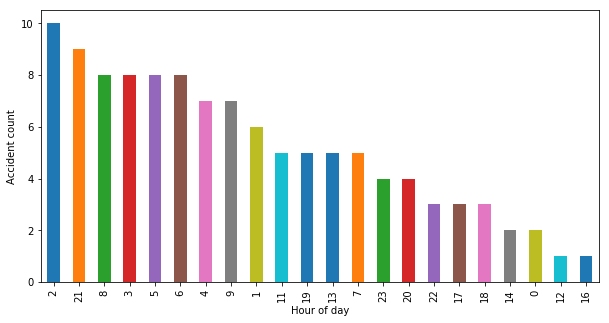

In [21]:
plt.figure(figsize=(10,5))
plt.xlabel("Hour of day")
plt.ylabel("Accident count")
df['hour'].value_counts().plot(kind='bar');

This graph shows that most of the accidents take place when there is low visibility, i.e. night time or wee hours. We will not go deep into exact hour at which accident took place because the sources which provided this information gave an estimate of accident timings. That is why 10:00 hrs and 15:00 hrs have no count. Some accidents took place around evening so we put them in 17-18 hrs range, and similar is the case for 10:00 hrs. We are not interested in exact time of accident, for this purpose we have created **daytime** column previously to compare trends which shows effect of visibility based on hour of accident.

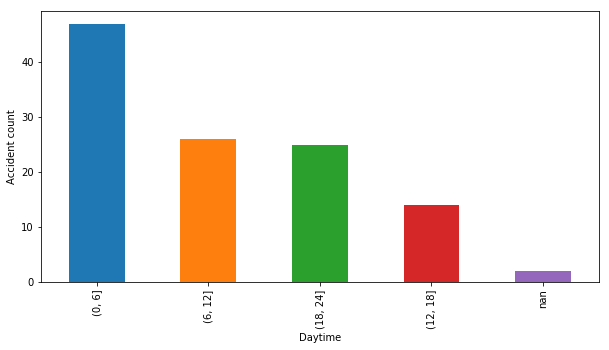

In [22]:
plt.figure(figsize=(10,5))
plt.xlabel("Daytime")
plt.ylabel("Accident count")
df['daytime'].value_counts().plot(kind='bar');

12:00 to 18:00 hours is the time when less accidents happen. Visibility factor can be inferred from this relation. Accidents are more likely to occur when there is low visibility. Most of the accidents occur during night time, as seen from the data. Day time has also considerable amount of acccidents but on the basis of visibility criteria it is almost half compared to night time. Increasing security during night time can help in preventing these mishaps.

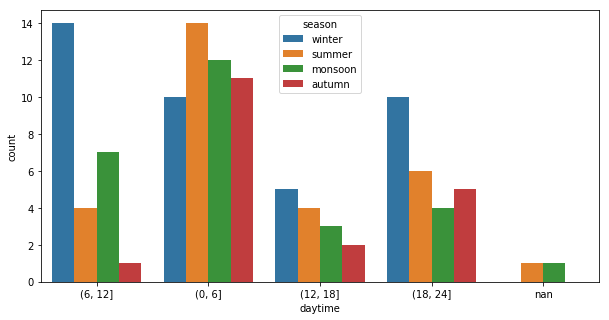

In [23]:
plt.figure(figsize=(10,5))
plt.xlabel("Daytime")
plt.ylabel("Accident count")
sns.countplot(x = 'daytime', hue = 'season', data = df);

Daytime has second largest number of accidents because of accidents in day in winter season.

<a id='cz'></a>
### 7.3. Cause

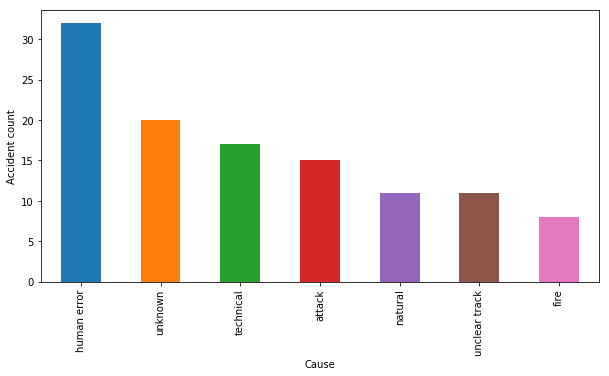

In [24]:
plt.figure(figsize=(10,5))
plt.xlabel("Cause")
plt.ylabel("Accident count")
df['cause'].value_counts().plot(kind='bar');

Let us see what each value on x-axis stands for:

* **attack**: this includes all external forces like:

    + bombing by terrorists;
    + attack by local people;
    + sabotage;
    + one case is of hijack[5].

* **fire**: fire caught inside train led to few accidents. This is the least frequent cause of accident because it was caused when passengers unintentionally carried some inflammable item with them. Electrical short circuits also caused fire.

* **human error**: this includes human negligence at large scale. This includes:

    + improper signalling
    + speeding by driver
    + unmanned level crossing
    + negligence about train timings on level-crossing
    + one incident includes people watching sample fireworks while standing on railway track

* **natural**: these are beyond one's control. Natural causes are:

    + heavy rain
    + flash flood
    + dense fog

* **technical**: this includes malfunctioning of railway system:

    + no prior alert for driver to stop;
    + poor maintenance of track;
    + some tracks are pending for reconstruction[7];
    + brake fail;
    + no alert about poor tracks ahead.

* **unclear track**: technically this should also come under **technical** cause but track was occupied in many cases so we are considering it as a separate factor:

    + boulders on track
    + some vehicle was already on track(includes trains and roadways vehicles)
    + some roadways vehicle stuck on track

Mostly human error is reponsible for train accidents because they are in some way directly related to the short-comings in system. Mistakes like improper signalling, poor maintenance of track are very sensitive areas when it comes to railway security. In some cases train driver overshot the red signal. These mistakes should not be tolerated at such large scale. Speeding can be easily avoided if there is proper timing for crossings and loop-line entry.

<a id='env'></a>
### 7.4. Environment

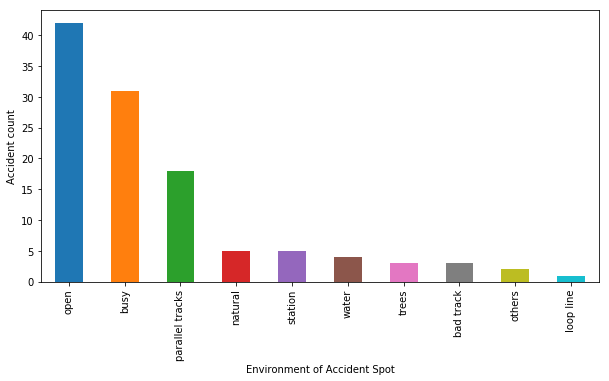

In [25]:
plt.figure(figsize=(10,5))
plt.xlabel("Environment of Accident Spot")
plt.ylabel("Accident count")
df['env'].value_counts().plot(kind='bar');

There is no perfect conclusion from this graph but if we see the environment which has most number of accidents then open area, busy track, and parallel track have high frequency of accident in the last 16 years. 

Let us see what these features mean:

* Open area:

This includes tracks which were away from residential areas and surrounded by non-agricultural land. 

* Busy track:

It includes all the cases when the track was occupied, whether it is roadways vehicle, obstacle, another train, and humans.

* Parallel tracks:

More than one track on the route.

Possible reasons why there are more accident can be seen if we include the daytime factor:

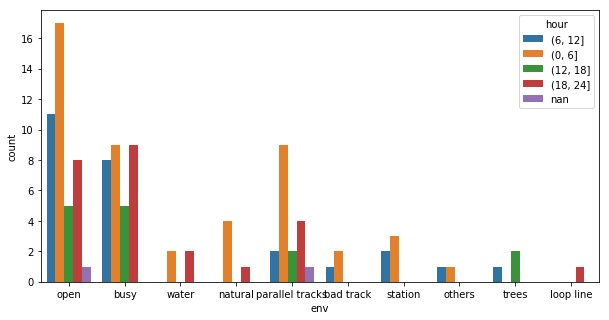

In [26]:
plt.figure(figsize=(10,5))
plt.xlabel("Environment of Accident Spot")
plt.ylabel("Accident count")
sns.countplot(x = 'env', hue = 'daytime', data = df);
plt.legend(title = 'hour', loc='upper right');

We can clearly see that visibility is a key factor here. Such a large peak for night time in every environment shows how frequently accidents occur in low light. More on this in **season** section.

Let us perform a Chi-squared test of dependence for **environment and daytime**:

In [56]:
chi2, p1, dof, expected = chi2_contingency(pd.crosstab(df.env, df.daytime))
p1/2

0.33486050334080486

As the p-value is greater than the significance level 0.01, we do not reject the null hypothesis that the environment of accident is independent of daytime. We are not taking significance level of 0.05.

<a id='season'></a>
### 7.5. Season

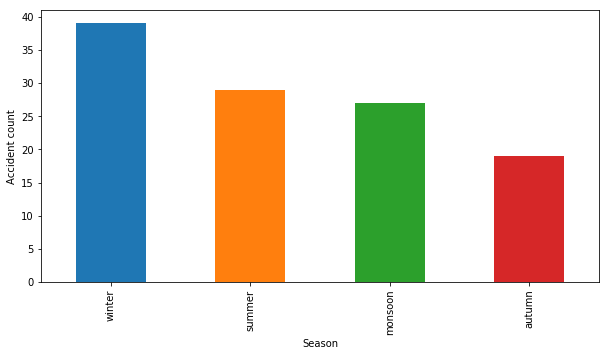

In [57]:
plt.figure(figsize=(10,5))
plt.xlabel("Season")
plt.ylabel("Accident count")
df['season'].value_counts().plot(kind='bar');

These peaks do not directly convey the number of accidents in each season because every season has different time-span. Autumn lasts for shortest period and so count is also less for it. We can include more features in this plot to generalise our idea.

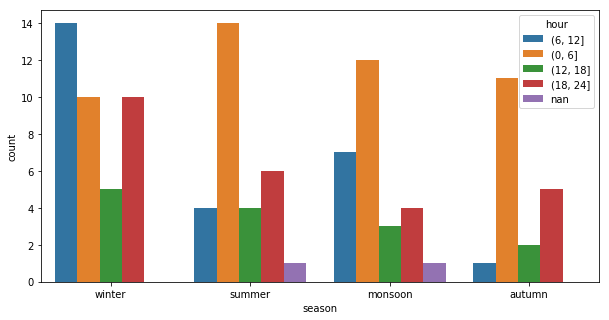

In [27]:
plt.figure(figsize=(10,5))
plt.xlabel("Season")
plt.ylabel("Accident count")
sns.countplot(x = 'season', hue = 'daytime', data = df);
plt.legend(title = 'hour', loc='upper right');

Now let us perform Chi-squared test of dependence for **season and daytime**:

In [59]:
chi2, p2, dof, expected = chi2_contingency(pd.crosstab(df.season, df.daytime))
p2/2

0.1532142925606064

In [60]:
100*((p1/2) - (p2/2))/(p1/2)

54.245337675828466

As the p-value here is also greater than the 0.01 significance level, we do not reject the null hypothesis that season and daytime are independent. But, if we compare it with environment-daytime pair, p-value for season-daytime is 52.82% less than that of environment-daytime pair. This does mean that season-daytime pair are more close to being interdependent pair(or say correlated pair) than environment-daytime pair. 

Reflect back on the environment criteria and daytime criteria. Visibility played a major role there for causing accidents.

Here, each season is affected during night time. In winter, however, accidents are still frequent during morning time due to dense fog. In winter, accidents are more in morning than in night time because precautions are taken during night time to avoid accidents due to fog. Though in daytime, some cases are there when dense fog causes visibility problems resulting in accidents.

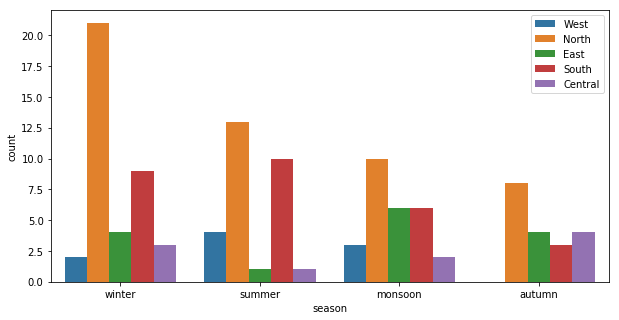

In [61]:
plt.figure(figsize=(10,5))
plt.xlabel("Season")
plt.ylabel("Accident count")
sns.countplot(x = 'season', hue = 'region', data = df);
plt.legend(loc='upper right');

Let us see perform Chi-squared test of dependence for season and region:

In [62]:
chi2, p3, dof, expected = chi2_contingency(pd.crosstab(df.season, df.region))
p3/2

0.10368750836521881

As the p-value for this pair is 0.11 which is higher than the significance level 0.01, we cannot reject the null hypothesis that these two variable are independent of each other.

In South, accidents are more common in summer because of hot climate there. North, on the other hand, has harsh climatic conditions here which is a more severe cause than tropical Southern India. Dense fog in winter affects the timing of train.

Overall, winter sees most number of accidents, reason is decrease in visibility due to dense fog.

<a id='t_type'></a>
### 7.6. Train type

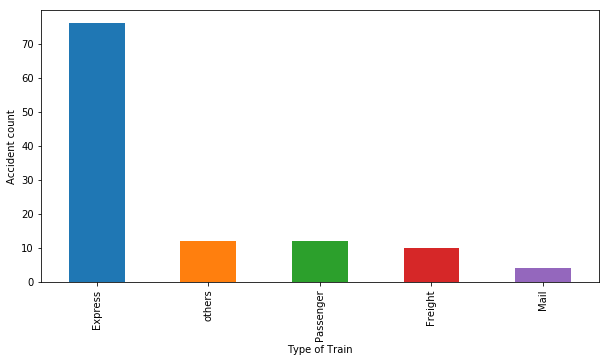

In [63]:
plt.figure(figsize=(10,5))
plt.xlabel("Type of Train")
plt.ylabel("Accident count")
df['train_type'].value_counts().plot(kind='bar');

This observation is as expected. Major causes are violation of signals and speeding.

Compared to other trains, it is difficult for express and freight trains to lower their speed when they see obstacles in their way. Obstacles can be like:

* boulders on track;

* some vehicle on track; and

* unexpected engagement of roadways vehicle on level-crossing.

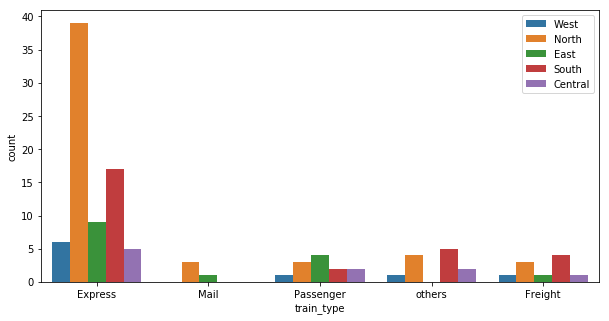

In [64]:
plt.figure(figsize=(10,5))
plt.xlabel("Type of Train")
plt.ylabel("Accident count")
sns.countplot(x = 'train_type', hue = 'region', data = df);
plt.legend(loc='upper right');

Let us perform Chi-squared test of dependence for train type and region:

In [65]:
chi2, p4, dof, expected = chi2_contingency(pd.crosstab(df.train_type, df.region))
p4/2

0.22840641590284233

No strong relation between train type and region of accident. A p-value of 0.161 means that we cannot reject the null hypothesis that season and train types are independent of each other. We can conclude from this statistic that there is no specific part of India where one type of train is running more frequently. 

2 accidents occurred where passenger were sitting on the top of train. This is the result of **dense population** and in order to accommodate facility for increasing population, new railway tracks are laid wherever necessary[8].

On the other side, it is important to maintain the track also. As of 2014 statistics, 5300 km of track was due for renewal[8]. This target keeps increasing if laying of new tracks and maintenance of old tracks are not balanced.

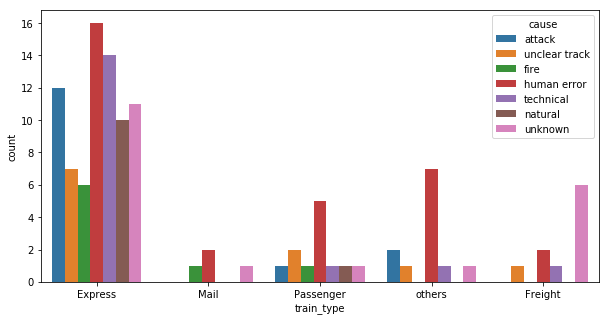

In [28]:
plt.figure(figsize=(10,5))
plt.xlabel("Type of Train")
plt.ylabel("Accident count")
sns.countplot(x = 'train_type', hue = 'cause', data = df);
plt.legend(title = 'cause', loc='upper right');

Let us perform Chi-squared test of dependence for train type and cause of accident:

In [67]:
chi2, p5, dof, expected = chi2_contingency(pd.crosstab(df.train_type, df.region))
p5/2

0.22840641590284233

In [68]:
df.train_type.value_counts()

Express      76
others       12
Passenger    12
Freight      10
Mail          4
Name: train_type, dtype: int64

As the p-value is still higher than 0.01 significance level, but if we relax the significance level criteria to 0.1 then we can conclude to some extent that cause and train type are related with each other. But 0.1 level of significance is very high. Chance of accident is high if we are testing for express trains.

High green peaks show that human error is most responsible for almost every type of train accident. Driver's mistake comes under this case but there is no right way to avoid accidents cause by driver's mistake. Some ways can be deploying experienced drivers, changing drivers on shift-basis for long journey trains, checking physical fitness of driver, etc.

Next are technical and external attacks. Attacks on railway system has decreased in recent years but this attack factor counts for sabotage cases also. Technical fault was for speeding and improper signalling, that's why technical error is largest for express trains. Drivers get signals late, some times they are unable to receive signal at right time. Accidents caused by unclear tracks can be avoided by providing information about bad track at right time. People should follow rules when they are near level crossing.

<a id='ans'></a>
## 8. Answers

**Q1.** On which time of day more accidents are happening? Does visibility play a major role in accidents?

**A1.**

In [69]:
df.daytime.value_counts()

(0, 6]      47
(6, 12]     26
(18, 24]    25
(12, 18]    14
nan          2
Name: daytime, dtype: int64

Accidents are more during night time. Out of 114 observations, accidents in night time (49 + 25 = 74) are greater than that in daytime ( = 40). They can be prevented by avoid speeding at night time. 

To increase efficiency and to enhance safety in train operations, Advanced Signaling System with Panel/Route Relay/Electronic Interlocking (PI/RRI/EI) along with Multi Aspect Colour Light Signals have been progressively provided at 5,317 stations i.e. about 85% of Broad Gauge stations of Indian Railways, replacing outdated Multi Cabin Mechanical Signaling system involving a large number of human interfaces. Route
Relay Interlocking/Electronic Interlocking at 8 major stations namely Barddhaman, Firozpur, Jakhal, Tambaram, Nagda, Gomoh, Agra Cant & Chheoki have been provided during the year 2014-15[12]. 

**Q2.** In which season accidents are more frequent?

**A2.**

In [70]:
df.season.value_counts()

winter     39
summer     29
monsoon    27
autumn     19
Name: season, dtype: int64

Accidents are more frequent in winter season, followed by monsoon. The reason is climatic condition. Heavy rain in monsoon wets railway track, flash floods disrupt train route, dense fog affects movement of train. 

Indian Railways is developing an effective accident prevention system to help save lives and increase the efficiency of its service. The fleet of locomotives will be equipped with a 'third eye' to avert train collisions, derailment and accidents on unmanned railway crossings. The technology involves a radar-based device that alerts drivers to any physical obstructions on railway tracks ahead, preventing accidents and breakdowns. This will prove to be more useful at night and in foggy conditions when drivers have to constantly look outside the locomotive to assess weather conditions[13].

The system called 'Terrain Imaging for Diesel Drivers - Infra-red Enhanced Optical and radar assisted' (Tri-netra) has been developed for India by foreign agencies[13].

**Q3.** Which region of the country has experienced more accidents?

**A3.**

In [71]:
df.region.value_counts()

North      52
South      28
East       15
Central    10
West        9
Name: region, dtype: int64

Northern region has experienced more accidents. This is due to high population density in northern states. As of 2011 Census of India, U.P. alone contributes to 16.5 % of nation's population[9]. Higher population density means more number of railway tracks for accommodation.

**Q4.** What is the environment of accident spot (like open area, flood affected area or bad track?

**A4.**

In [72]:
df.env.value_counts()

open               42
busy               31
parallel tracks    18
station             5
natural             5
water               4
trees               3
bad track           3
others              2
loop line           1
Name: env, dtype: int64

Open area includes tracks away from agricultural field and residential areas. Accidents are frequent in opens area because there is only one track and fast moving train collides before even changing track or slowing down. 

It has been decided to progressively eliminate all unmanned level crossings by (i) closing unmanned crossings having NIL/negligible Train Vehicle Units (TVUs), (ii) merger of unmanned level crossing with nearby unmanned/manned gates or Road Under Bridge or Road Over Bridge or Subway by construction of diversion road, (iii) provision of Subways/Road Under Bridges. The Unmanned Level Crossings which cannot be eliminated by the above means will be progressively manned based on the volume of rail road traffic (TVU) and visibility conditions[14].

**Q5.** Which type of trains suffer more accidents(express, passenger, freight, etc.)?

**A5.**

In [73]:
df.train_type.value_counts()

Express      76
others       12
Passenger    12
Freight      10
Mail          4
Name: train_type, dtype: int64

Express trains suffer more accident because of speeding and signal overshooting. Derailment occurs when taking sharp turn at high speed[10]. Many cases include binary collision of express train with other express/passenger train. Passenger train is usually running at low speed when collision takes place. It is the express train which rams into it[11].

Technological aids of Automatic Train Protection System to
loco pilots to avoid collisions due to Signal Passing at Danger (SPAD)
or over speeding have been put on trial on Indian Railways[12].

Train Protection and Warning System (TPWS) is a proven Automatic Train Protection System to avoid train accidents on account of human error of Signal Passing at Danger (SPAD) or over-speeding. As a pilot project, TPWS has been provided on Chennai-Gummidipundi Suburban Section of Southern Railway, Hazrat Nizamuddin - Agra Section of Northern/North Central Railway and Dum Dum-Kavi Subhash section of Kolkata Metro[14].

<a id='conc'></a>
## 9. Conclusion

From the data of 16 years, it is clear that some causes can be prevented and some can't. Natural causes are very rare in causing accidents. Every year train accidents take place and exact cause of accident is not known in many cases. If the investigation of accidents are carried out in more depth then improvements can be made effectively. Accidents happening inside train, like fire, are less nowadays. Human negligence is major cause and will remain the cause in future if no special attention is given by train drivers, roadways riders, people crossing tracks, vehicles crossing tracks, etc. 

There are some limitations of this data:

* it was not possible to account for each accident because of very brief report of some incidents on news websites

* this report does not address solution for external attacks

* condition (old or newly launched) of trains is not known

* this report addresses accident counts over years 2002-2017. It does not analyse trends in casualties because we wanted to prevent them directly by knowing the cause of accidents.

<a id='abb'></a>
## 10. Abbreviations used

* c: Central Railway Zone
* e: Eastern Railway Zone
* ec: East Central Railway Zone
* eco: East Coast Railway Zone
* k: Konkan Railway Zone
* n: Northern Railway Zone
* nc: North Central Railway Zone
* ne: North Eastern Railway Zone
* nef: North East Frontier Railway Zone
* nw: North Western Railway Zone
* s: Southern Railway Zone
* sc: South Central Railway Zone
* se: South Eastern Railway Zone
* sw: South Western Railway Zone
* w: Western Railway Zone
* wc: West Central Railway Zone

<a id='refs'></a>

## 11. References

1. [List of Indian rail accidents](https://en.wikipedia.org/wiki/List_of_Indian_rail_accidents)

2. [586 train accidents in last 5 years](https://timesofindia.indiatimes.com/india/586-train-accidents-in-last-5-years-53-due-to-derailments/articleshow/60141578.cms)

3. [Climate of India](https://en.wikipedia.org/wiki/Climate_of_India)

4. [List of Uttar Pradesh train accidents](https://en.wikipedia.org/wiki/List_of_Uttar_Pradesh_train_accidents)

5. [Hijack leads to train collision, 4 die](http://www.thehindu.com/todays-paper/Hijack-leads-to-train-collision-4-die/article16626772.ece)

6. [Three die in train accident](https://timesofindia.indiatimes.com/city/kochi/Three-die-in-train-accident/articleshow/12063072.cms)

7. [Railways’ target: Laying 9.5 km of tracks every day](https://economictimes.indiatimes.com/industry/transportation/railways/railways-target-laying-9-5-km-of-tracks-every-day/articleshow/57195430.cms)

8. [Indian Railways: Lifeline of the nation](http://www.indianrailways.gov.in/railwayboard/uploads/directorate/finance_budget/Budget_2015-16/White_Paper-_English.pdf)

9. [2011 Census of India](https://en.wikipedia.org/wiki/2011_Census_of_India)

10. [British tourists killed as India train derails](http://www.bbc.com/news/uk-34232974)

11. [India train crash kills 30](http://news.bbc.co.uk/2/hi/south_asia/2025207.stm)

12. [INDIAN RAILWAYS ANNUAL REPORT AND ACCOUNTS 2014-15](http://www.indianrailways.gov.in/railwayboard/uploads/directorate/stat_econ/IRSP_2014-15/IR_Annual_Report%20%26%20Accounts_2014-15/11.pdf)

13. [Indian Railways to use radar-based 'third eye' device to warn drivers about hazards on the line](http://www.dailymail.co.uk/indiahome/indianews/article-3683522/Indian-Railways-use-radar-based-eye-device-warn-drivers-hazards-line.html)

14. [Measures To Prevent Railway Accidents](http://pib.nic.in/newsite/PrintRelease.aspx?relid=155175)